<font size="10">Data Scraping and Model Testing</font>

<font size="7">Part 1: Data Scraping</font>

<font size="5">This project seeks to see if it is possible to predict the category of score from the Ask Reddit subreddit</font>

<font size="3">To begin, I start by importing all the the needed packages. I've gone back and added packages along the way as packages came up that I needed, but I like to keep all my packages in one place, this way I'm not importing mid work.</font>

In [1248]:
import praw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.linalg import diagsvd

<font size="3">Here I create a read only instance of a Reddit app using the Python Reddit API Wrapper (PRAW). This was a package I was looking forward to using, as Reddit a website that I use frequently, and I was excited because of how simple the package looked to scrape data from the site.</font>

In [359]:
read_only = praw.Reddit(client_id="Client ID removed for protection",
                        client_secret="Client Secret removed for protection",
                        user_agent="arranwasslittle_ufl")

In [360]:
askr = read_only.subreddit("AskReddit")

<font size="5">This function scrapes the new, top, and hot pages of the subreddit</font>

<font size="3">This is my main data scraping funtion. For each page in a sub, it loops through a section and grabs data from each post. I decided on the different data points due to content knowledge as a user as to what could be an indicator for success.</font>

<font size="3">A note on 'Score_flag': this is the variable that the model will predict on. You see I've categorized the score into three groups: Under 100, between 100 and 1000, and above 1000. These labels were chosen given a bit of exploration into the distribution of scores, and my own knowledge that the majority of posts score under 100, witht the next two groups the more interesting to try and predict.</font>

In [537]:
def getData(sub, num_posts):
    data_dict = {"ID":[], "Title":[], "Score":[], "Score_flag":[], "NSFW":[], "Serious":[], "Time":[]}
    pages = [askr.hot(limit=num_posts), 
             askr.top('week', limit=num_posts/2), 
             askr.top('month', limit=num_posts/2),
             askr.top('year', limit=num_posts/2),
             askr.new(limit=num_posts)]
    for page in pages:
        for post in page:
            data_dict["ID"].append(post.id)
            data_dict["Title"].append(post.title)
            data_dict["Score"].append(post.score)
            if (post.score >= 0) & (post.score <= 100):
                score_flag = 0
            elif (post.score > 100) & (post.score <= 1000):
                score_flag = 1
            elif (post.score > 1000):
                score_flag = 2
            else:
                score_flag = 3
            data_dict["Score_flag"].append(score_flag)
            if post.over_18:
                nsfw = 1
            else:
                nsfw = 0
            data_dict["NSFW"].append(nsfw)
            if post.link_flair_text == "Serious Replies Only":
                ser = 1
            else:
                ser = 0
            data_dict["Serious"].append(ser)
            time = datetime.datetime.utcfromtimestamp(post.created_utc)
            hour = int(format(time.hour))
            minute = int(format(time.minute))
            if minute >= 30:
                hour += 1
            if hour > 24:
                hour = 0
            data_dict["Time"].append(hour)
    return pd.DataFrame(data_dict)

In [540]:
data1 = getData(askr, 5000)

<font size='3'>Here is the raw data. We now need to transform the 'Title' data into a normalized word frequency table.</font>

In [541]:
data1

,ID,Title,Score,Score_flag,NSFW,Serious,Time
0,u5nqgm,What famous person’s downfall are you waiting ...,13993,2,0,0,14
1,u5idpj,What can't you believe still exists in 2022?,13682,2,0,0,8
2,u5mnem,What’s the biggest legal scam?,1213,2,0,0,13
3,u5as3p,What’s the most underrated sex act?,11331,2,1,0,0
4,u586dj,"What’s the most, WTF, film you’ve seen?",22199,2,1,0,22
...,...,...,...,...,...,...,...
4944,u5sn35,"Mall Santa's of Reddit, what's the saddest thi...",1,0,0,0,18
4945,u5smu9,"if you die, what will you do?",0,0,0,0,18
4946,u5smtt,What is something that still surprises you to ...,2,0,0,0,18
4947,u5smrc,What is the craziest thing that you saw happen...,1,0,0,0,18


<font size="5">This function creates a normalized frequency table of the words used in the title</font>

<font size="3">Here we stem each word, add the frequency of that word in the sentence, and append the sentence onto the larger data frame. Then, we replace all the null values with 0, and normalize each row.


Stemming is process by which words from the same root are reduced to that root. For example, the words "sings" and "singing" would both become "sing". This way we the meaning of each sentence is preservered and more easily compared.</font>

In [1093]:
def cleanData(data):
    snow = nltk.stem.SnowballStemmer('english')
    titles = []
    df = pd.DataFrame()
    for title in data['Title']:
        temp = nltk.tokenize.word_tokenize(title)
        cut = [snow.stem(word) for word in temp]
        row = {}
        for stem in cut:
            num = False
            try:
                int(stem)
                num = True
            except:
                if stem in row:
                    row[stem] += 1
                else:
                    row[stem] = 1
        df = df.append(row, ignore_index = True)
    df = df.fillna(0)
    norms = pd.DataFrame(np.sqrt(np.square(df).sum(axis=1)))
    df = df.div(norms.iloc[:,0],axis=0)
    return df

In [1094]:
data2 = cleanData(data1)

<font size="3">Here is the cleaned and created 'Title' data. Now we need to concatenate it with the original data set to create our final data frame.</font>

In [1095]:
data2

,what,famous,person,’,s,downfal,are,you,wait,for,...,repel,tweak,vague/unclear,possess,ingest,medicin,cashier,exit,mall,santa
0,0.277350,0.27735,0.27735,0.277350,0.277350,0.27735,0.27735,0.277350,0.27735,0.27735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.333333,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.333333,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.353553,0.00000,0.00000,0.353553,0.353553,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.333333,0.00000,0.00000,0.333333,0.333333,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.235702,0.00000,0.00000,0.471405,0.235702,0.00000,0.00000,0.235702,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,0.223607,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.223607,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223607,0.223607
4945,0.301511,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.603023,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4946,0.301511,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.301511,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4947,0.258199,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.258199,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [1096]:
df = pd.concat([data1,data2], axis=1)
df = df.drop_duplicates()

In [1530]:
df.to_csv('data_model_building_test.csv',index=False)

<font size='5'>Here is our final data set!</font>

In [1099]:
df

,ID,Title,Score,Score_flag,NSFW,Serious,Time,what,famous,person,...,repel,tweak,vague/unclear,possess,ingest,medicin,cashier,exit,mall,santa
0,u5nqgm,What famous person’s downfall are you waiting ...,13993,2,0,0,14,0.277350,0.27735,0.27735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,u5idpj,What can't you believe still exists in 2022?,13682,2,0,0,8,0.333333,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,u5mnem,What’s the biggest legal scam?,1213,2,0,0,13,0.353553,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,u5as3p,What’s the most underrated sex act?,11331,2,1,0,0,0.333333,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,u586dj,"What’s the most, WTF, film you’ve seen?",22199,2,1,0,22,0.235702,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,u5sn5t,"Retail associates and cashiers of Reddit , wha...",1,0,0,0,18,0.171499,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.171499,0.171499,0.000000,0.000000
4944,u5sn35,"Mall Santa's of Reddit, what's the saddest thi...",1,0,0,0,18,0.223607,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.223607,0.223607
4945,u5smu9,"if you die, what will you do?",0,0,0,0,18,0.301511,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4947,u5smrc,What is the craziest thing that you saw happen...,1,0,0,0,18,0.258199,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


<font size='7'>Part 2: Model Testing</font>

<font size='3'>This part of the process took the most time. Not shown here is the many iterations of the model. I ended up choosing to reduce the data use SVD to the 1000 most important vectors. This way the training process was sped up.  I also ended up <b>only including text data</b>. I dropped the Not Safe For Work (NSFW) flag, the Serious flag, and the Time, as the model ended up performing better.Next I played around with perceptron layers of different shapes and sizes. The results can be seen below.</font>

<font size='3'>SVD works by deconstructing the matrix into two orthonormal basis matrices, and one sizing matrix, which when all three are multiplied together we get the original matrix. I used one of the orthonormal matrices to generate the principal components of the original matrix, and took the top k vectors (in this case 1000). While I was able to get similar accuracy scores without it, reducing the data from ~4000 variables to 1000 drastically reduced model training time, and improved testing accuracy by a percent or two. I would suspect that this happens due to removing “clutter” or useless data points, honing in on the most important parts of each data point.</font>

In [1147]:
X = df.iloc[:,7:]
y = df.iloc[:,3]

In [1148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [1243]:
X_train.shape

(3606, 3906)

In [1241]:
u, s, vt = np.linalg.svd(X_train)

In [1249]:
sd = diagsvd(s,3606,3906)

In [1242]:
u.shape

(3606, 3606)

In [1244]:
vt.shape

(3906, 3906)

In [1253]:
sd.shape

(3606, 3906)

In [1502]:
X_train_red = (X_train.values)@vt
X_train_red_1000 = X_train_red[:,:1000]

In [1503]:
X_test_red = (X_test.values)@vt
X_test_red_1000 = X_test_red[:,:1000]

In [1504]:
X_train_red_1000

array([[-0.02058839, -0.00409303,  0.02159516, ...,  0.01346033,
        -0.01571886, -0.0055454 ],
       [-0.0274282 , -0.00379476,  0.03273116, ..., -0.00895144,
         0.00972526, -0.00430286],
       [ 0.10040782, -0.01316268,  0.00766885, ...,  0.00914211,
        -0.0019839 , -0.00494012],
       ...,
       [ 0.00328192, -0.01033232,  0.01340382, ...,  0.00872265,
         0.00173925,  0.00073621],
       [ 0.01019859,  0.00786623,  0.00240105, ...,  0.01293478,
        -0.01239823,  0.00015583],
       [-0.04916128, -0.01196779, -0.14119474, ..., -0.0008329 ,
        -0.00300044,  0.00321266]])

In [1418]:
y_train_cat = keras.utils.to_categorical(y_train)

In [1481]:
def build_model(num_features):
    model = keras.models.Sequential()

    model.add(keras.Input(shape=(num_features,)))
    
    model.add(keras.layers.Dense(num_features, activation = 'relu', use_bias=False))
        
    model.add(keras.layers.Dense(1000, activation = 'relu', use_bias=False))
        
    model.add(keras.layers.Dense(20, activation = 'relu', use_bias=False))
    
    model.add(keras.layers.Dense(3, activation='softmax', use_bias=False))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

<font size='3'>The actual Multi Layer Perceptron (MLP) neural network consisted of 4 layers, 3 of which were hidden layers and the last of which outputted a probability vector for the category predictions. A MLP works by layering nodes with functions that are fitted with weights. That means each data point is weighted and summed, then put into an activation function. The layers of perceptrons were all fitted with “ReLu” activation nodes. The ReLu function is simple, where it takes in a value and outputs the value, or 0 if the value is less than 0. So as each data point is passed through a “wall” of nodes, the output is an output vector of the size of that many nodes. The process is repeated until the last layer, where the last layer uses the softmax activation function to predict a probability vector. The softmax activation function can be seen here: </font>

<font size='6'>$$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$ </font>

<font size='3'>Another important feature about the network is that I used cross entropy for the loss function. The cross entropy equation is a common function to measure how different two probability distributions are, since when the two are identical the cross entropy is simply the entropy of the probability distribution. Below is the equation for cross entropy where $p$ is the true probability (which would be a vector of size three like [0,0,1] indicating it has the label 2) and $q$ is the network’s predicted probability distribution. This loss function is what the networks uses gradient descent on, minimizing the loss function of the actual and predicted probability vector.</font>

<font size='6'>$$X(p,q) = \sum_i p_i log_2(\frac{1}{q_i})$$ </font>

In [1509]:
model = build_model(X_train_red_1000.shape[1])
model.summary()

Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_694 (Dense)            (None, 1000)              1000000   
_________________________________________________________________
dense_695 (Dense)            (None, 1000)              1000000   
_________________________________________________________________
dense_696 (Dense)            (None, 20)                20000     
_________________________________________________________________
dense_697 (Dense)            (None, 3)                 60        
Total params: 2,020,060
Trainable params: 2,020,060
Non-trainable params: 0
_________________________________________________________________


In [1510]:
history = model.fit(X_train_red_1000, y_train_cat, batch_size = 100, epochs = 15)

Epoch 1/15
37/37 [==============================] - 1s 12ms/step - loss: 0.9169 - accuracy: 0.5821
Epoch 2/15
37/37 [==============================] - 0s 13ms/step - loss: 0.8335 - accuracy: 0.6034
Epoch 3/15
37/37 [==============================] - 0s 12ms/step - loss: 0.7307 - accuracy: 0.6753
Epoch 4/15
37/37 [==============================] - 1s 14ms/step - loss: 0.5585 - accuracy: 0.7612
Epoch 5/15
37/37 [==============================] - 1s 14ms/step - loss: 0.3694 - accuracy: 0.8392
Epoch 6/15
37/37 [==============================] - 1s 16ms/step - loss: 0.2327 - accuracy: 0.8957
Epoch 7/15
37/37 [==============================] - 0s 12ms/step - loss: 0.1344 - accuracy: 0.9673
Epoch 8/15
37/37 [==============================] - 0s 12ms/step - loss: 0.1013 - accuracy: 0.9703
Epoch 9/15
37/37 [==============================] - 0s 13ms/step - loss: 0.1206 - accuracy: 0.9603
Epoch 10/15
37/37 [==============================] - 1s 14ms/step - loss: 0.0946 - accuracy: 0.9762
Epoch 11/

In [1512]:
y_pred_probs = model.predict(X_test_red_50)

In [1513]:
y_pred = np.argmax(y_pred_probs, 1)

In [1514]:
predictions = pd.DataFrame(y_pred, columns=['y_pred'])

In [1515]:
predictions['y_test'] = y_test.reset_index(drop=True)

<font size='5'>Model Analysis</font>

<font size='3'>Here we can see the confusion matrix, accuracy score, precision, and recall. Given these, we can see that the model gets that the majority of posts should be a 0, however it struggles with the 1 label. While this model is not necessarily a top performed, given the data set, these were the top performing hyperparamters.</font>

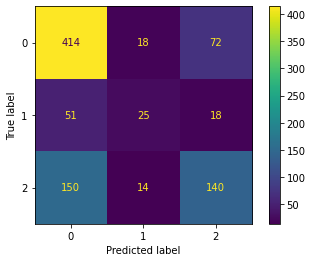

In [1529]:
cm = confusion_matrix(predictions['y_test'], predictions['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp. .plot()
plt.show()

<font size='3'>Accuracy is a simple metric of all of the true positive and negatives (in this case the diagonal of the confusion matrix) divided by the total number of values.</font>

<font size='3'>Precision is the true positives divided by the true positives and false positives. In this case it is the sum of each element in the diagonal divided by the sum of their respective column.</font>

<font size='3'>Recall is the true positives divded by the true positives and the false negatives. In this case it is the sum of each element in the diagonal divided by the sum of their respective rows.</font>

In [1522]:
print('Accuracy:',(predictions['y_pred'] == predictions['y_test']).sum()/predictions.shape[0])

Accuracy: 0.6419068736141907


In [1518]:
print('Precision for 0:', cm[0,0]/cm[:,0].sum())
print('Precision for 1:', cm[1,1]/cm[:,1].sum())
print('Precision for 2:', cm[2,2]/cm[:,2].sum())

0.6731707317073171
0.43859649122807015
0.6086956521739131


In [1526]:
print('Recall for 0:', cm[0,0]/cm[0,:].sum())
print('Recall for 1:', cm[1,1]/cm[1,:].sum())
print('Recall for 2:', cm[2,2]/cm[2,:].sum())

Recall for 0: 0.8214285714285714
Recall for 1: 0.26595744680851063
Recall for 2: 0.4605263157894737


<font size='4'>With a satisfactory accuracy rate, the final model can be trained on the entire data set.</font>

<font size='7'>Time to train the final model!</font>

In [1532]:
X

,what,famous,person,’,s,downfal,are,you,wait,for,...,repel,tweak,vague/unclear,possess,ingest,medicin,cashier,exit,mall,santa
0,0.277350,0.27735,0.27735,0.277350,0.277350,0.27735,0.27735,0.277350,0.27735,0.27735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.333333,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.333333,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.353553,0.00000,0.00000,0.353553,0.353553,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.333333,0.00000,0.00000,0.333333,0.333333,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.235702,0.00000,0.00000,0.471405,0.235702,0.00000,0.00000,0.235702,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,0.171499,0.00000,0.00000,0.171499,0.171499,0.00000,0.00000,0.171499,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.171499,0.171499,0.000000,0.000000
4944,0.223607,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.223607,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.223607,0.223607
4945,0.301511,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.603023,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4947,0.258199,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.258199,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [1533]:
y

0       2
1       2
2       2
3       2
4       2
       ..
4943    0
4944    0
4945    0
4947    0
4948    0
Name: Score_flag, Length: 4508, dtype: int64

In [1534]:
U, S, Vt = np.linalg.svd(X.values)

In [1539]:
X_red = ((X.values)@vt)[:,:1000]

In [1544]:
y_cat = keras.utils.to_categorical(y)

In [1548]:
final_model = build_model(X_red.shape[1])
final_model.summary()

Model: "sequential_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_710 (Dense)            (None, 1000)              1000000   
_________________________________________________________________
dense_711 (Dense)            (None, 1000)              1000000   
_________________________________________________________________
dense_712 (Dense)            (None, 20)                20000     
_________________________________________________________________
dense_713 (Dense)            (None, 3)                 60        
Total params: 2,020,060
Trainable params: 2,020,060
Non-trainable params: 0
_________________________________________________________________


In [1549]:
history = final_model.fit(X_red, y_cat, batch_size = 100, epochs = 15)

Epoch 1/15
46/46 [==============================] - 1s 14ms/step - loss: 0.8986 - accuracy: 0.5890
Epoch 2/15
46/46 [==============================] - 1s 13ms/step - loss: 0.7800 - accuracy: 0.6617
Epoch 3/15
46/46 [==============================] - 1s 14ms/step - loss: 0.6151 - accuracy: 0.7411
Epoch 4/15
46/46 [==============================] - 1s 14ms/step - loss: 0.4237 - accuracy: 0.8174
Epoch 5/15
46/46 [==============================] - 1s 22ms/step - loss: 0.2284 - accuracy: 0.9241
Epoch 6/15
46/46 [==============================] - 1s 13ms/step - loss: 0.1236 - accuracy: 0.9643
Epoch 7/15
46/46 [==============================] - 1s 15ms/step - loss: 0.0651 - accuracy: 0.9820
Epoch 8/15
46/46 [==============================] - 1s 18ms/step - loss: 0.0454 - accuracy: 0.9894
Epoch 9/15
46/46 [==============================] - 2s 37ms/step - loss: 0.0452 - accuracy: 0.9894
Epoch 10/15
46/46 [==============================] - 1s 19ms/step - loss: 0.0324 - accuracy: 0.9927
Epoch 11/

In [1550]:
final_model.save('final_model')

INFO:tensorflow:Assets written to: final_model/assets
